# Quá trình lan truyền silhouette trong mô hình GaitSet

In [ ]:
!git clone https://github.com/AbnerHqC/GaitSet.git

Cloning into 'GaitSet'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 106 (delta 29), reused 22 (delta 22), pack-reused 62 (from 1)
Receiving objects: 100% (106/106), 54.42 MiB | 9.91 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [ ]:
%cd /content/GaitSet

/content/GaitSet


## Chuẩn bị dữ liệu đầu vào

### Khai báo thư viện

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Đọc ảnh (64x64)
Giả sử đầu vào là 1 sequence với 2 frame

(64, 64)


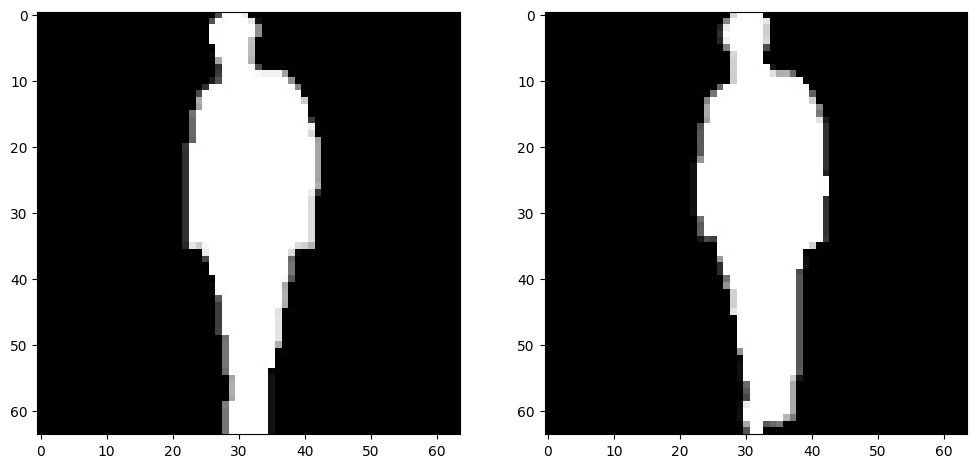

In [ ]:
frame1_path = r"/content/001-bg-01-000-001.png"
frame2_path = r"/content/001-bg-01-000-008.png"
# frame3_path = r"/content/001-bg-01-000-009.png"
# frame4_path = r"/content/001-bg-01-000-011.png"

frame1 = cv2.imread(frame1_path, cv2.IMREAD_GRAYSCALE)
frame2 = cv2.imread(frame2_path, cv2.IMREAD_GRAYSCALE)
# frame3 = cv2.imread(frame3_path, cv2.IMREAD_GRAYSCALE)
# frame4 = cv2.imread(frame3_path, cv2.IMREAD_GRAYSCALE)

print(frame1.shape)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(frame1, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(frame2, cmap='gray')
# plt.subplot(1, 4, 3)
# plt.imshow(frame3, cmap='gray')
# plt.subplot(1, 4, 4)
# plt.imshow(frame4, cmap='gray')
plt.show()

### Cắt ảnh (64x44)

(64, 44)


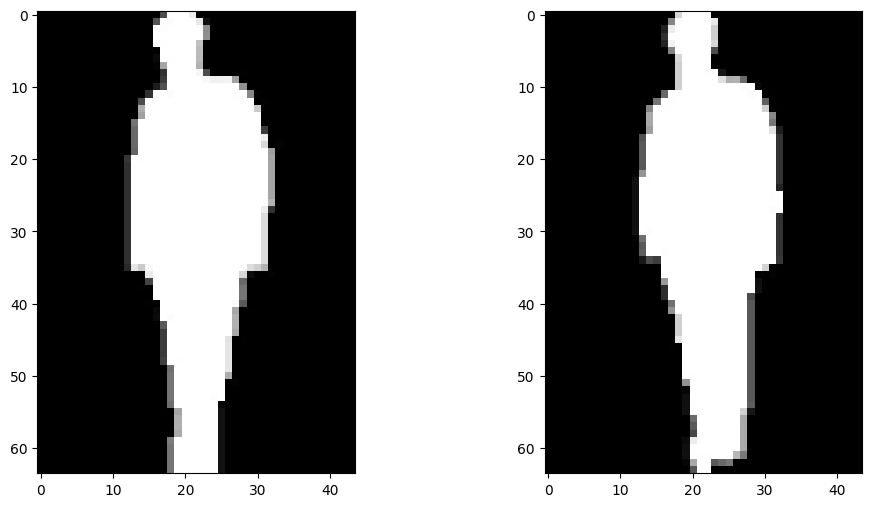

In [ ]:
cut_padding = int(64 / 64 * 10)
frame1_cropped = frame1[:, cut_padding:-cut_padding].astype('float32') / 255.0
frame2_cropped = frame2[:, cut_padding:-cut_padding].astype('float32') / 255.0
# frame3_cropped = frame3[:, cut_padding:-cut_padding].astype('float32') / 255.0
# frame4_cropped = frame3[:, cut_padding:-cut_padding].astype('float32') / 255.0

print(frame1_cropped.shape)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(frame1_cropped, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(frame2_cropped, cmap='gray')
# plt.subplot(1, 4, 3)
# plt.imshow(frame3_cropped, cmap='gray')
# plt.subplot(1, 4, 4)
# plt.imshow(frame3_cropped, cmap='gray')
plt.show()

### Tạo tensor đầu vào từ các
([batch_size, frame_num, height, width])

In [ ]:
sequence1 = np.array([frame1_cropped, frame2_cropped])
# sequence2 = np.array([frame3_cropped, frame4_cropped])

batch = torch.tensor([sequence1], dtype=torch.float32)

print(batch.shape)

torch.Size([1, 2, 64, 44])


## Khởi tạo mô hình

In [ ]:
from model.network.gaitset import SetNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SetNet(hidden_dim=256).to(device).eval()

model_path = r"/content/GaitSet/work/checkpoint/GaitSet/GaitSet_CASIA-B_73_False_256_0.2_128_full_30-80000-encoder.ptm"
checkpoint = torch.load(model_path, map_location=device)

state_dict = checkpoint.get('model_state_dict', checkpoint)
clean_state = {k.replace('module.', '', 1) if k.startswith('module.') else k: v for k, v in state_dict.items()}

model.load_state_dict(clean_state)

<All keys matched successfully>

## Trích xuất đặc trưnng

### Main Pipeline

Thêm chiều channel

([batch_size, frame_num, channel, height, width])

In [ ]:
x = batch.unsqueeze(2)

print(x.shape)

torch.Size([1, 2, 1, 64, 44])


Lớp tích chập C1 với kernel 5x5

torch.Size([1, 2, 32, 64, 44])


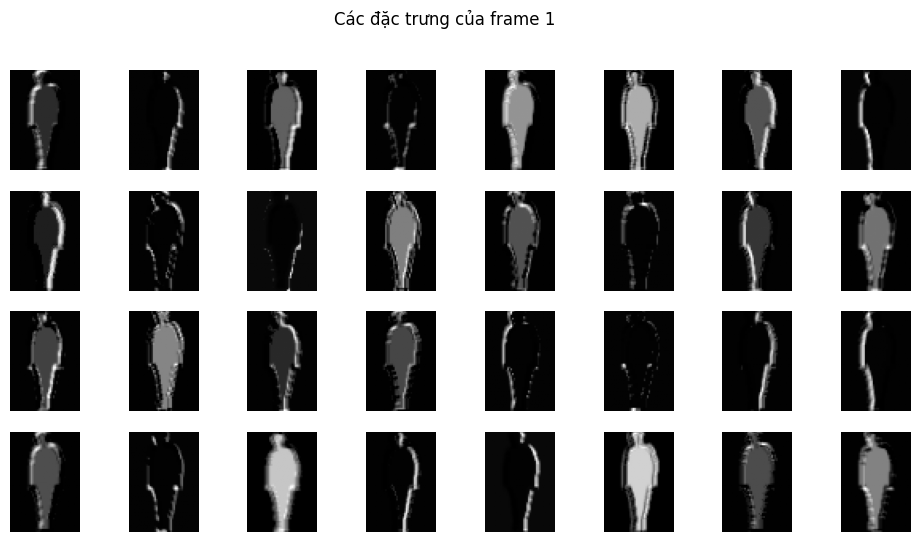

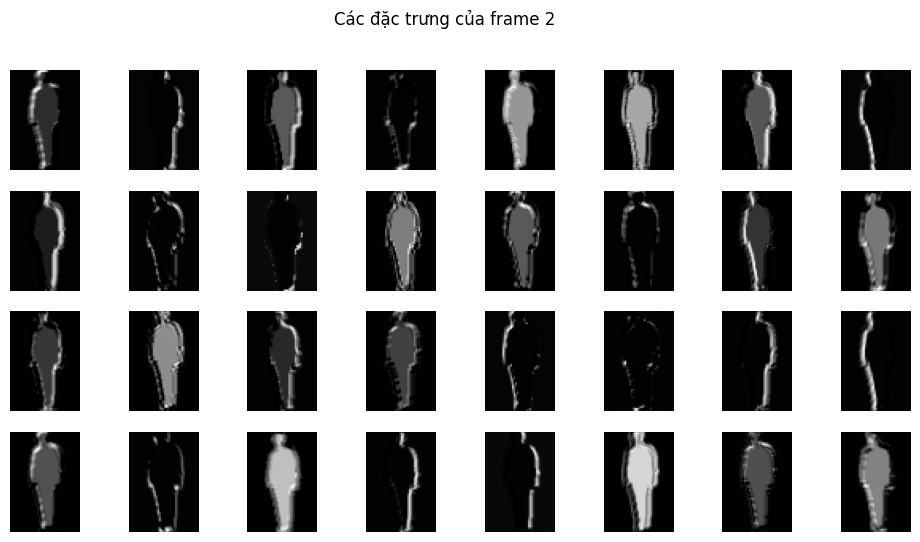

In [ ]:
x = model.set_layer1(x)

print(x.shape)
for i in range(x.size(1)):
    plt.figure(figsize=(12, 6))
    for j in range(x.size(2)):
        plt.subplot(4, 8, j + 1)
        plt.imshow(x[0, i, j, :, :].detach().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Các đặc trưng của frame {i + 1}')
    plt.show()

Lớp tích chập C2 với kernel 3x3 và lớp max pooling 2x2 với bước nhảy là 2

torch.Size([1, 2, 32, 32, 22])


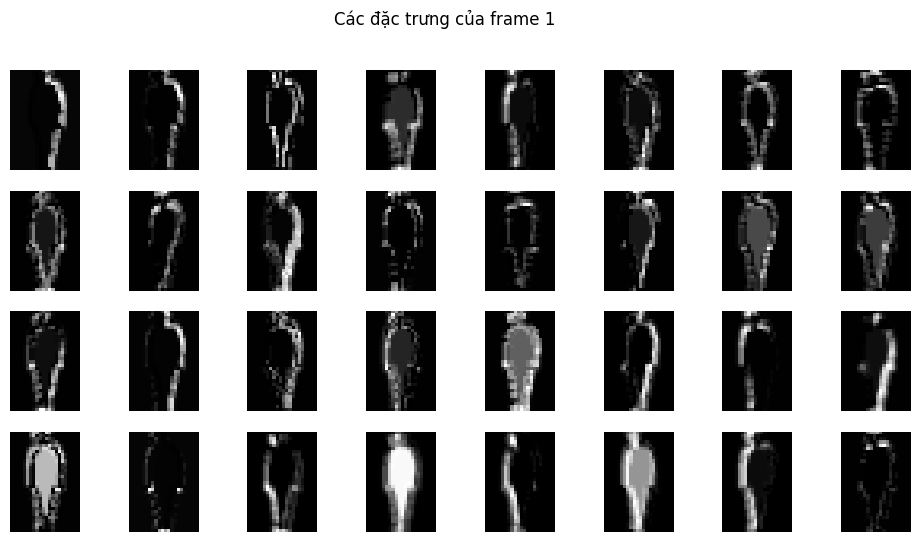

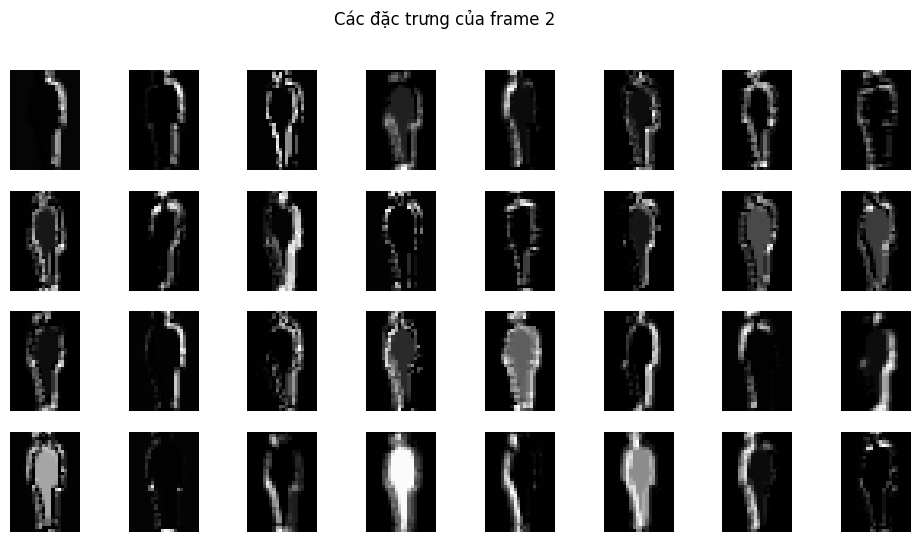

In [ ]:
x = model.set_layer2(x)
x1 = x

print(x.shape)
for i in range(x.size(1)):
    plt.figure(figsize=(12, 6))
    for j in range(x.size(2)):
        plt.subplot(4, 8, j + 1)
        plt.imshow(x[0, i, j, :, :].detach().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Các đặc trưng của frame {i + 1}')
    plt.show()

Lớp tích chập C3 với kernel 3x3

torch.Size([1, 2, 64, 32, 22])


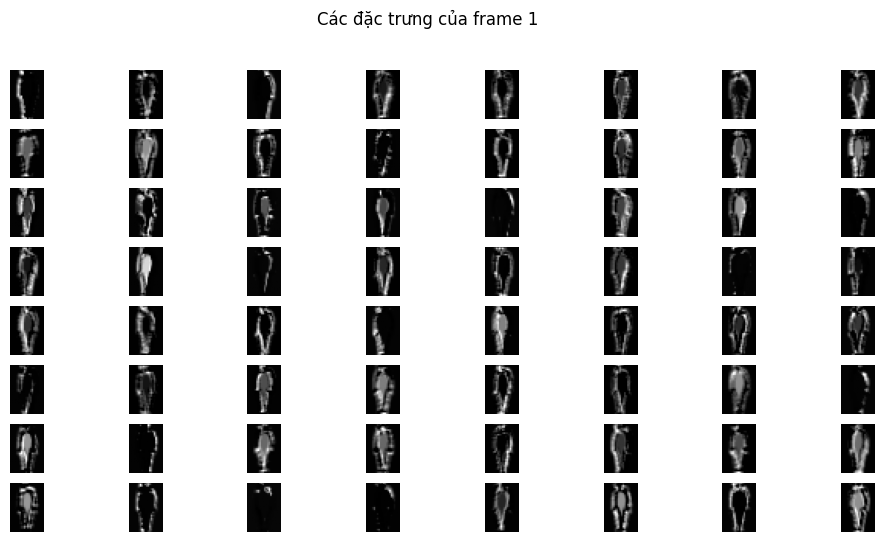

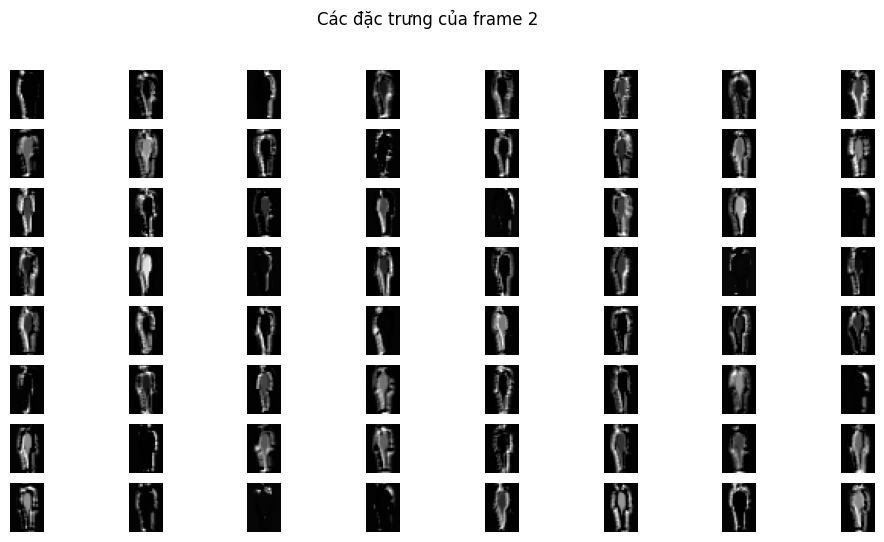

In [ ]:
x = model.set_layer3(x)

print(x.shape)
for i in range(x.size(1)):
    plt.figure(figsize=(12, 6))
    for j in range(x.size(2)):
        plt.subplot(8, 8, j + 1)
        plt.imshow(x[0, i, j, :, :].detach().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Các đặc trưng của frame {i + 1}')
    plt.show()

Lớp tích chập C4 với kernel 3x3 và lớp max pooling 2x2 với bước nhảy là 2

torch.Size([1, 2, 64, 16, 11])


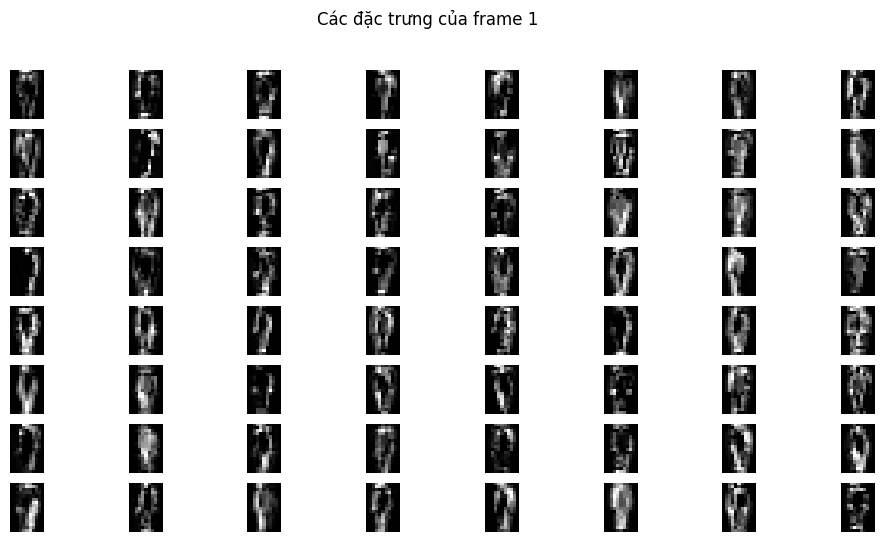

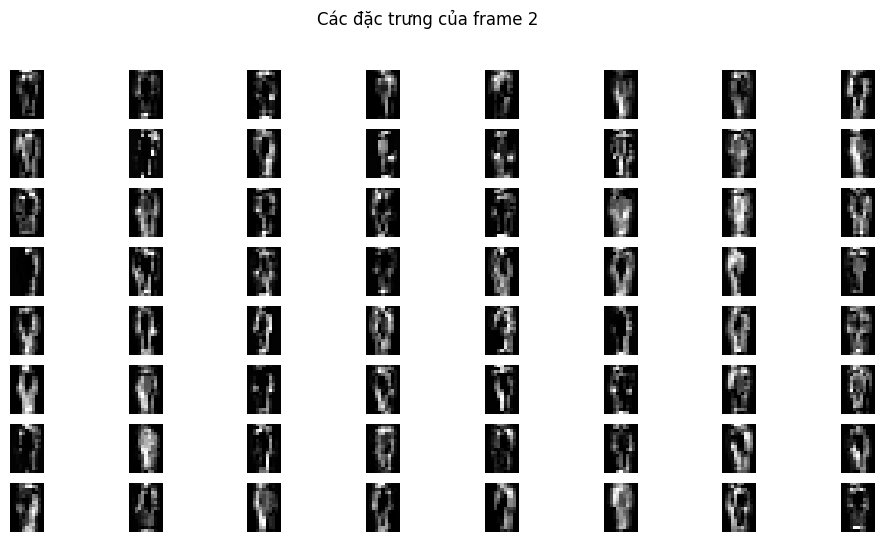

In [ ]:
x = model.set_layer4(x)
x2 = x

print(x.shape)
for i in range(x.size(1)):
    plt.figure(figsize=(12, 6))
    for j in range(x.size(2)):
        plt.subplot(8, 8, j + 1)
        plt.imshow(x[0, i, j, :, :].detach().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Các đặc trưng của frame {i + 1}')
    plt.show()

Lớp tích chập C5 với kernel 3x3

torch.Size([1, 2, 128, 16, 11])


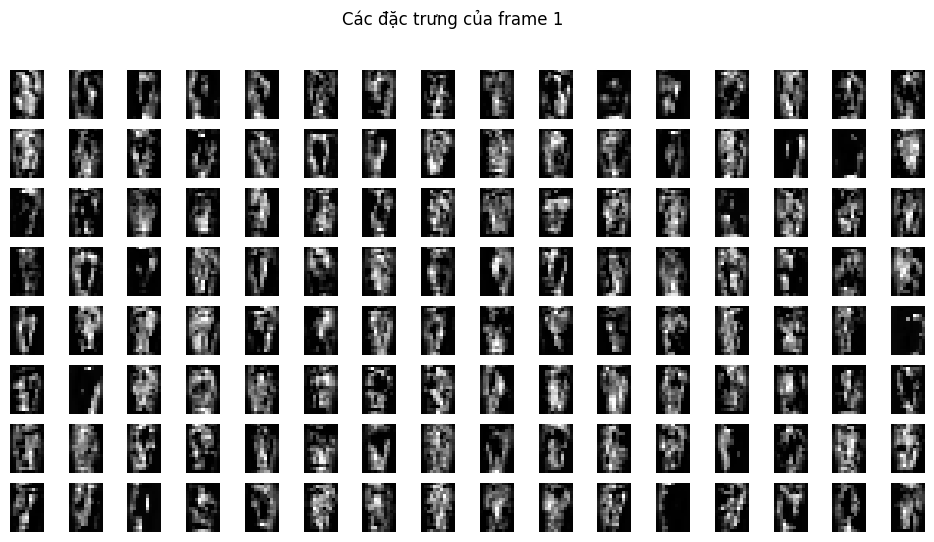

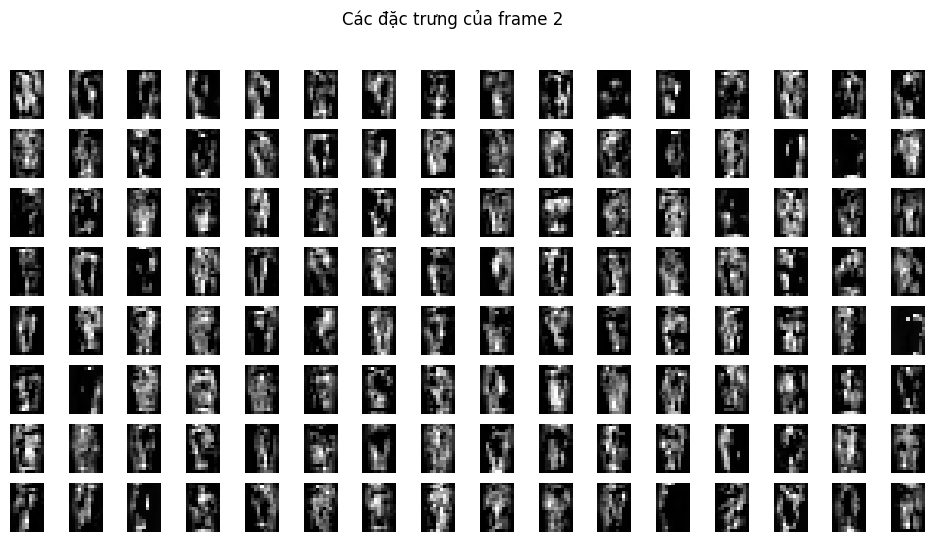

In [ ]:
x = model.set_layer5(x)

print(x.shape)
for i in range(x.size(1)):
    plt.figure(figsize=(12, 6))
    for j in range(x.size(2)):
        plt.subplot(8, 16, j + 1)
        plt.imshow(x[0, i, j, :, :].detach().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Các đặc trưng của frame {i + 1}')
    plt.show()

Lớp tích chập C6 với kernel 3x3

torch.Size([1, 2, 128, 16, 11])


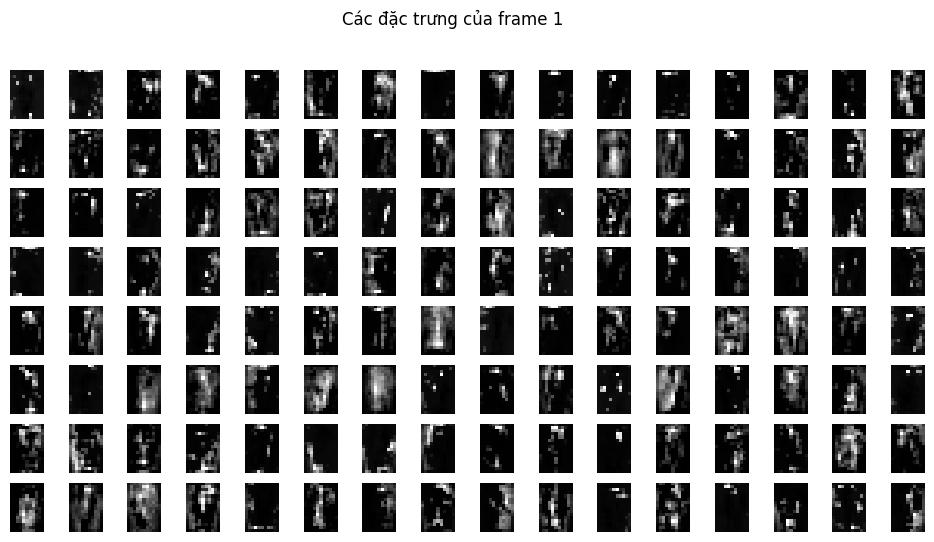

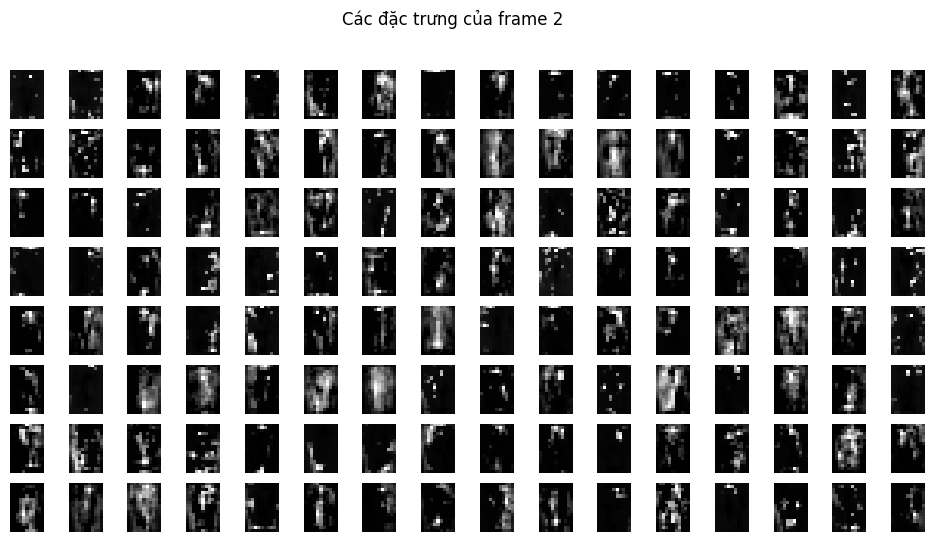

In [ ]:
x = model.set_layer6(x)

print(x.shape)
for i in range(x.size(1)):
    plt.figure(figsize=(12, 6))
    for j in range(x.size(2)):
        plt.subplot(8, 16, j + 1)
        plt.imshow(x[0, i, j, :, :].detach().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Các đặc trưng của frame {i + 1}')
    plt.show()

Set Pooling ở cuối Main Pipeline

torch.Size([1, 128, 16, 11])


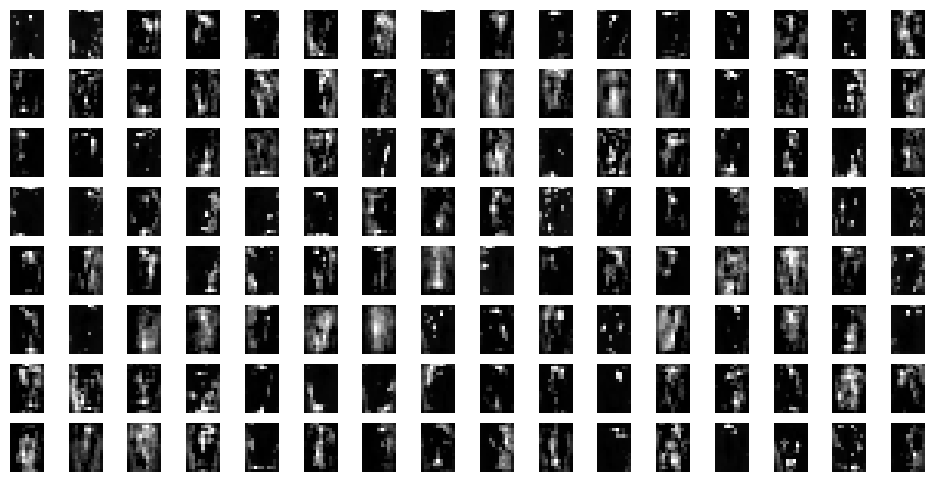

In [ ]:
x = model.frame_max(x)[0]

print(x.shape)
plt.figure(figsize=(12, 6))
for i in range(x.size(1)):
    plt.subplot(8, 16, i + 1)
    plt.imshow(x[0, i, :, :].detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

### Multilayer Global Pipeline

Set Pooling sau lớp max pooling thứ nhất trong Main Pipeline, sau đó sử dụng nó để thực hiện lớp tích chập C3 với kernel 3x3 trong MGP.

torch.Size([1, 64, 32, 22])


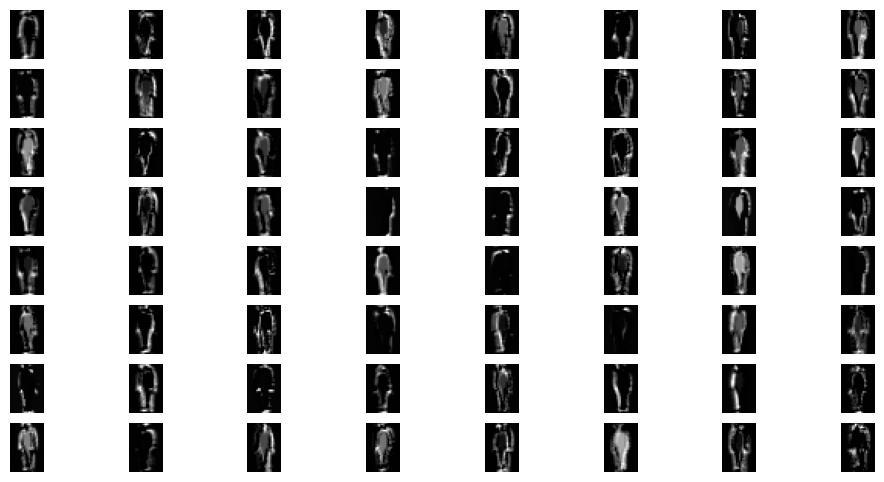

In [ ]:
gl = model.gl_layer1(model.frame_max(x1)[0])

print(gl.shape)
plt.figure(figsize=(12, 6))
for i in range(gl.size(1)):
    plt.subplot(8, 8, i + 1)
    plt.imshow(gl[0, i, :, :].detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

Lớp tích chập C4 với kernel 3x3 trong MGP

torch.Size([1, 64, 32, 22])


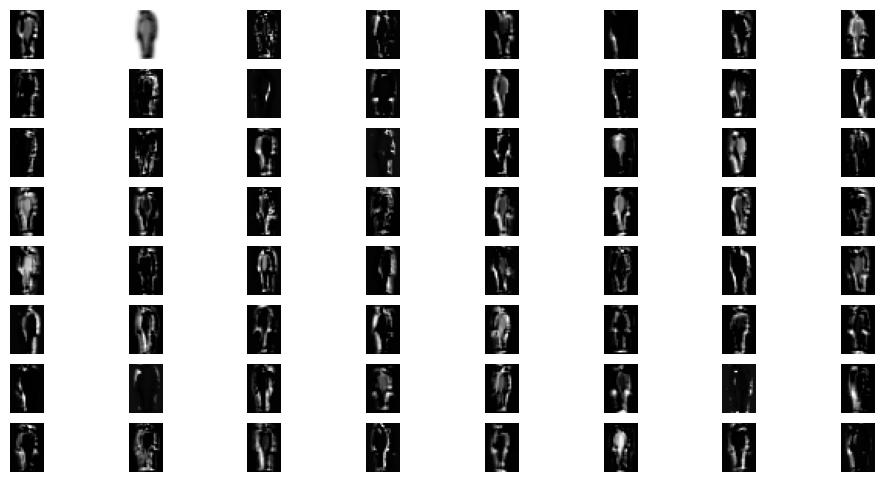

In [ ]:
gl = model.gl_layer2(gl)

print(gl.shape)
plt.figure(figsize=(12, 6))
for i in range(gl.size(1)):
    plt.subplot(8, 8, i + 1)
    plt.imshow(gl[0, i, :, :].detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

Lớp max pooling 2x2 với bước nhảy là 2 trong MGP

torch.Size([1, 64, 16, 11])


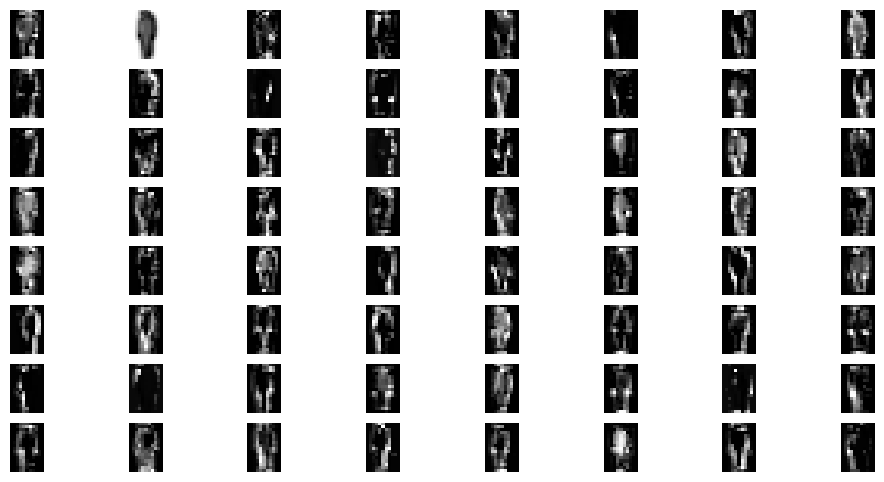

In [ ]:
gl = model.gl_pooling(gl)

print(gl.shape)
plt.figure(figsize=(12, 6))
for i in range(gl.size(1)):
    plt.subplot(8, 8, i + 1)
    plt.imshow(gl[0, i, :, :].detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

Set Pooling sau lớp max pooling thứ hai trong Main Pipeline, tiếp theo cộng nó với đầu ra của lớp max pooling trong MGP, sau đó thực hiện lớp tích chập C5 với kernel 3x3 trong MGP

torch.Size([1, 128, 16, 11])


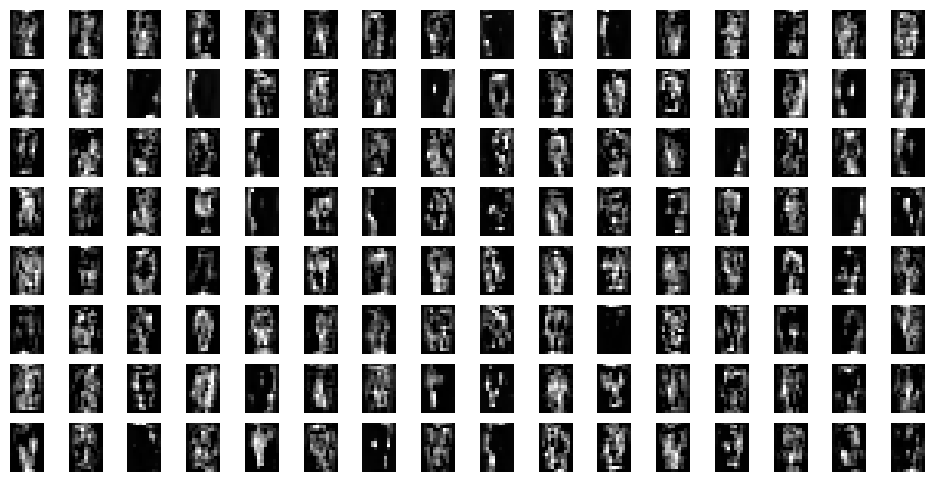

In [ ]:
gl = model.gl_layer3(gl + model.frame_max(x2)[0])

print(gl.shape)
plt.figure(figsize=(12, 6))
for i in range(gl.size(1)):
    plt.subplot(8, 16, i + 1)
    plt.imshow(gl[0, i, :, :].detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

Lớp tích chập C6 với kernel 3x3 trong MGP

torch.Size([1, 128, 16, 11])


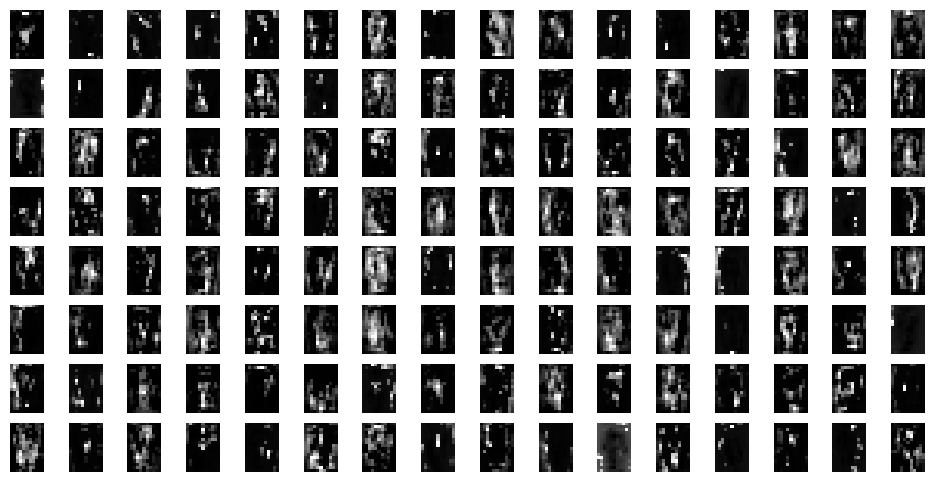

In [ ]:
gl = model.gl_layer4(gl)

print(gl.shape)
plt.figure(figsize=(12, 6))
for i in range(gl.size(1)):
    plt.subplot(8, 16, i + 1)
    plt.imshow(gl[0, i, :, :].detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

Cộng đầu ra của lớp tích chập C6 trong MGP với đầu ra của Set Pooling ở cuối Main Pipeline

torch.Size([1, 128, 16, 11])


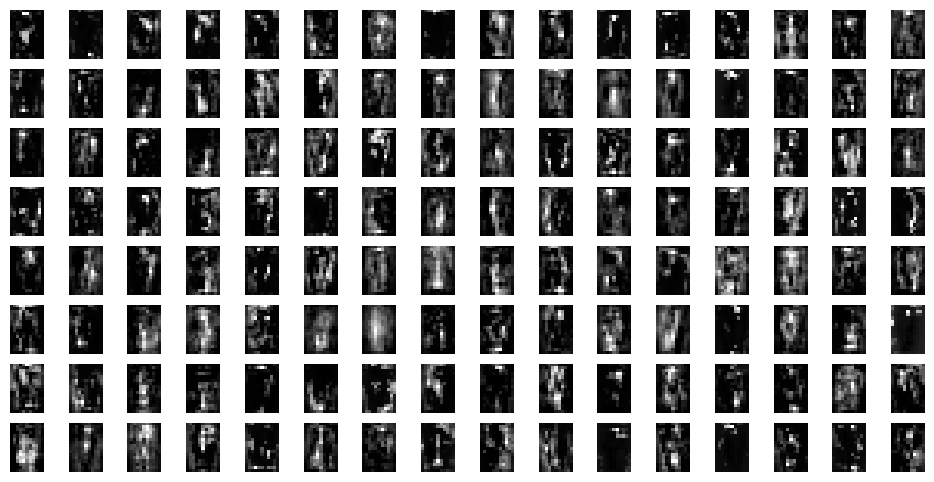

In [ ]:
gl = gl + x

print(gl.shape)
plt.figure(figsize=(12, 6))
for i in range(gl.size(1)):
    plt.subplot(8, 16, i + 1)
    plt.imshow(gl[0, i, :, :].detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

### Horizontal Pyramid Mapping

In [ ]:
feature = list()
n, c, h, w = gl.size()

Thực hiện HPP (Horizontal Pyramid Pooling) cho đầu ra của Main Pipeline

In [ ]:
for num_bin in model.bin_num:
    z = x.view(n, c, num_bin, -1)
    z = z.mean(3) + z.max(3)[0]
    print(z.shape)
    feature.append(z)

torch.Size([1, 128, 1])
torch.Size([1, 128, 2])
torch.Size([1, 128, 4])
torch.Size([1, 128, 8])
torch.Size([1, 128, 16])


Thực hiện HPP (Horizontal Pyramid Pooling) cho đầu ra của MGP

In [ ]:
for num_bin in model.bin_num:
    z = gl.view(n, c, num_bin, -1)
    z = z.mean(3) + z.max(3)[0]
    print(z.shape)
    feature.append(z)

torch.Size([1, 128, 1])
torch.Size([1, 128, 2])
torch.Size([1, 128, 4])
torch.Size([1, 128, 8])
torch.Size([1, 128, 16])


Lớp Fully Connected

In [ ]:
feature = torch.cat(feature, 2).permute(2, 0, 1).contiguous()
feature = feature.matmul(model.fc_bin[0])
feature = feature.permute(1, 0, 2).contiguous()

print(feature.shape)

torch.Size([1, 62, 256])


## Hiển thị các tham số

In [ ]:
for name, param in model.named_parameters():
    if 'conv' in name and 'weight' in name:
        print(f"Layer: {name}")
        print(f"Weight shape: {param.data.shape}")
        print(param.data)
        print("----------------------------------------------------------------------------------")

Layer: set_layer1.forward_block.conv.weight
Weight shape: torch.Size([32, 1, 5, 5])
tensor([[[[-1.6722e-01, -1.6806e-01, -9.5073e-02, -4.7862e-02,  3.0315e-02],
          [-8.2069e-02, -1.4177e-03,  6.3177e-02,  1.6255e-02,  7.3387e-02],
          [ 1.1717e-01,  2.6366e-02,  1.6176e-01,  8.2146e-02,  2.0250e-02],
          [-6.4073e-02,  1.0722e-01,  3.8759e-02,  4.3571e-02,  8.5391e-02],
          [-4.4759e-02, -8.5287e-03,  3.0425e-02, -1.1037e-02, -1.0813e-01]]],


        [[[ 1.0738e-01,  3.2651e-02, -1.4310e-02, -1.2346e-01, -2.7701e-02],
          [ 1.6629e-01,  4.7078e-02,  4.1562e-02, -1.1460e-02, -1.6041e-01],
          [-6.7306e-02,  1.4381e-01,  1.6743e-01, -8.3897e-03, -1.6308e-01],
          [-1.1425e-01, -7.5692e-02,  1.2708e-01, -6.9838e-02,  3.6249e-02],
          [-6.9664e-04, -2.2632e-05, -1.1510e-01, -2.2676e-01, -6.1340e-02]]],


        [[[ 1.5144e-01,  6.5150e-02,  2.0956e-02,  5.0775e-02,  6.1513e-02],
          [ 1.5856e-01,  9.2017e-02, -2.7090e-02, -4.6384e-02

In [ ]:
from torchsummary import summary

summary(model, input_size=(30, 64, 44))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 44]             800
       BasicConv2d-2           [-1, 32, 64, 44]               0
          SetBlock-3       [-1, 30, 32, 64, 44]               0
            Conv2d-4           [-1, 32, 64, 44]           9,216
       BasicConv2d-5           [-1, 32, 64, 44]               0
         MaxPool2d-6           [-1, 32, 32, 22]               0
          SetBlock-7       [-1, 30, 32, 32, 22]               0
            Conv2d-8           [-1, 64, 32, 22]          18,432
       BasicConv2d-9           [-1, 64, 32, 22]               0
           Conv2d-10           [-1, 64, 32, 22]          36,864
      BasicConv2d-11           [-1, 64, 32, 22]               0
        MaxPool2d-12           [-1, 64, 16, 11]               0
           Conv2d-13           [-1, 64, 32, 22]          18,432
      BasicConv2d-14           [-1, 64,